##### Import Programs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, 
from sklearn.metrics import  roc_auc_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

##### Load Data

In [2]:
df = pd.read_csv('diabetic_data.csv', na_values=["?"])

/Users/allychrystal/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.isnull().sum().sort_values(ascending= False).head(10)

weight               98569
medical_specialty    49949
payer_code           40256
race                  2273
diag_3                1423
diag_2                 358
diag_1                  21
num_procedures           0
max_glu_serum            0
number_diagnoses         0
dtype: int64

##### Fill Nulls

In [5]:
# Drop columns with significant amount of nulls
df = df.drop(['weight', 'medical_specialty', 'payer_code'], axis=1)

In [6]:
# Fill remaining nulls
numerical_features = list(df._get_numeric_data().columns)
for i in numerical_features:
    df[i] = df[i].fillna(-999)
    
categorical_columns = list(df.select_dtypes(include=['object']).columns)
for i in categorical_columns:
    df[i] = df[i].fillna('None')

##### Feature Engineering: medication columns converted to binary: 0=No and 1=Steady/Up/Down

In [7]:
med_columns = ['metformin',
'repaglinide',
'nateglinide',
'chlorpropamide',
'glimepiride',
'acetohexamide',
'glipizide',
'glyburide',
'tolbutamide',
'pioglitazone',
'rosiglitazone',
'acarbose',
'miglitol',
'troglitazone',
'tolazamide',
'examide',
'citoglipton',
'insulin',
'glyburide-metformin',
'glipizide-metformin',
'glimepiride-pioglitazone',
'metformin-rosiglitazone',
'metformin-pioglitazone']

In [8]:
for i in med_columns:
    df[i] = df[i].map(lambda x: 0 if x=='No' else 1)

##### Feature Engineering: Total Medications

In [9]:
df['total_meds'] = df[med_columns].sum(axis=1)

In [10]:
df.total_meds.value_counts()

1    47314
0    23403
2    21873
3     7778
4     1335
5       58
6        5
Name: total_meds, dtype: int64

##### Eliminate columns dominated by a single value (>=95%)

In [11]:
eliminate = []
columns = list(df.columns) 

for i in columns:
    mode_count = df[i].value_counts().max()
    if mode_count >= 0.95* df.shape[0]:
        eliminate.append(i)
    else:
        pass

In [12]:
df = df.drop(eliminate, axis=1)
df.shape

(101766, 32)

##### Diagnostic Columns

In [13]:
diag_columns = ['diag_1','diag_2','diag_3']

In [14]:
df.loc[:, diag_columns].head(4)

,diag_1,diag_2,diag_3
0,250.83,None,None
1,276,250.01,255
2,648,250,V27
3,8,250.43,403


In [15]:
# Remove anything after '.'
for i in diag_columns:
    df[i] = df[i].str.split('.').str[0]

In [16]:
df.loc[:, diag_columns].head(4)

,diag_1,diag_2,diag_3
0,250,None,None
1,276,250,255
2,648,250,V27
3,8,250,403


In [17]:
# Duplicating Column
df['diag_1_new'] = df['diag_1']

In [18]:
# disease codes starting with V or E are recoded to 0
df.loc[df['diag_1'].str.contains('V'), ['diag_1_new']] = 0
df.loc[df['diag_1'].str.contains('E'), ['diag_1_new']] = 0

In [19]:
# Convert nulls to numeric (outlier) value
df['diag_1_new'] = df['diag_1_new'].replace('None', -999).astype(float)

In [20]:
df['diag_1_new'] = df['diag_1_new'].astype(float)

In [21]:
# iterate and recode disease codes between certain ranges to certain categories
for index, row in df.iterrows():
    if (row['diag_1_new'] >= 390 and row['diag_1_new'] < 460) or 
    (np.floor(row['diag_1_new']) == 785):
        df.loc[index, 'diag_1_new'] = 1
    elif (row['diag_1_new'] >= 460 and row['diag_1_new'] < 520) or 
    (np.floor(row['diag_1_new']) == 786):
        df.loc[index, 'diag_1_new'] = 2
    elif (row['diag_1_new'] >= 520 and row['diag_1_new'] < 580) or 
    (np.floor(row['diag_1_new']) == 787):
        df.loc[index, 'diag_1_new'] = 3
    elif (np.floor(row['diag_1_new']) == 250):
        df.loc[index, 'diag_1_new'] = 4
    elif (row['diag_1_new'] >= 800 and row['diag_1_new'] < 1000):
        df.loc[index, 'diag_1_new'] = 5
    elif (row['diag_1_new'] >= 710 and row['diag_1_new'] < 740):
        df.loc[index, 'diag_1_new'] = 6
    elif (row['diag_1_new'] >= 580 and row['diag_1_new'] < 630) or 
    (np.floor(row['diag_1_new']) == 788):
        df.loc[index, 'diag_1_new'] = 7
    elif (row['diag_1_new'] >= 140 and row['diag_1_new'] < 240):
        df.loc[index, 'diag_1_new'] = 8
    elif (row['diag_1_new'] == -999):
          pass
    else:
        df.loc[index, 'diag_1_new'] = 0

In [22]:
df['diag_1_new'].value_counts()

 1.0      30437
 0.0      18172
 2.0      14423
 3.0       9475
 4.0       8757
 5.0       6974
 7.0       5117
 6.0       4957
 8.0       3433
-999.0       21
Name: diag_1_new, dtype: int64

In [24]:
df = df.drop(diag_columns, axis=1)

##### Feature Engineering: Age

In [25]:
age_dict = {'[0-10)' : 10,
'[10-20)' : 20,
'[20-30)' : 30,
'[30-40)' : 40,
'[40-50)' : 50,
'[50-60)' : 60,
'[60-70)' : 70,
'[70-80)' : 80,
'[80-90)' : 90,
'[90-100)': 100}
df['age'] = df['age'].map(lambda x: age_dict[x])

##### Feature Engineering: Categorical Variables to Numerical

In [26]:
df.max_glu_serum.value_counts()

None    96420
Norm     2597
>200     1485
>300     1264
Name: max_glu_serum, dtype: int64

In [27]:
df['max_glu_serum'] = df['max_glu_serum'].map(lambda x: 0 if x=='None'else 1 if x=='Norm' else 2 if x=='>200' else 3)

In [28]:
df.max_glu_serum.value_counts()

0    96420
1     2597
2     1485
3     1264
Name: max_glu_serum, dtype: int64

In [29]:
df['A1Cresult'].value_counts()

None    84748
>8       8216
Norm     4990
>7       3812
Name: A1Cresult, dtype: int64

In [30]:
df['A1Cresult'] = df['A1Cresult'].map(lambda x: 0 if x=='None' else 1 if x=='Norm' else 2 if x=='>7' else 3)

In [31]:
df['A1Cresult'].value_counts()

0    84748
3     8216
1     4990
2     3812
Name: A1Cresult, dtype: int64

In [32]:
df.diabetesMed.value_counts()

Yes    78363
No     23403
Name: diabetesMed, dtype: int64

In [33]:
df['diabetesMed'] = df['diabetesMed'].map(lambda x: 0 if x=='No' else 1)

In [34]:
df.diabetesMed.value_counts()

1    78363
0    23403
Name: diabetesMed, dtype: int64

In [35]:
df.change.value_counts()

No    54755
Ch    47011
Name: change, dtype: int64

In [36]:
df['change'] = df['change'].map(lambda x: 0 if x=='No' else 1)

In [37]:
df.change.value_counts()

0    54755
1    47011
Name: change, dtype: int64

In [38]:
df.gender.value_counts()

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

In [39]:
df['gender'] = df['gender'].map(lambda x: 0 if x=='Female' else 1 if x =='Male' else -999)

In [40]:
df.gender.value_counts()

 0      54708
 1      47055
-999        3
Name: gender, dtype: int64

##### Feature Engineering: Admission, Discharge & Admission Source IDs

In [41]:
admission_dict = {
1 : "Emergency",
2 : "Emergency",
3 : "Elective",
4 : "Newborn",
5 : "NA",
6 : "NA",
7 : "Trauma",
8 : "NA"}
df['admission_type_id'] = df['admission_type_id'].map(lambda x: admission_dict[x])

In [42]:
discharge_dict = {
1 : "Discharge",
2 : "D/T",
3 : "D/T",
4 : "D/T",
5 : "D/T",
6 : "D/T",
7 : "LAMA",
8 : "D/T",
9 : "Admitted",
10 : "Newborn",
11 : "Expired",
12 : "Admitted",
13 : "Hospice",
14 : "Hospice",
15 : "D/T",
16 : "D/T",
17 : "D/T",
18 : "NA",
19 : "Expired",
20 : "Expired",
21 : "Expired",
22 : "D/T",
23 : "D/T",
24 : "D/T",
25 : "NA",
26 : "NA",
30 : "D/T",
27 : "D/T",
28 : "D/T",
29 : "D/T"}
df['discharge_disposition_id'] = df['discharge_disposition_id'].map(lambda x: discharge_dict[x])

In [43]:
source_dict = {
1 : "Referral",
2 : "Referral",
3 : "Referral",
4 : "Transfer",
5 : "Transfer",
6 : "Transfer",
7 : "ER",
8 : "Enforcement",
9 : "NA",
10 : "Transfer",
11 : "Newborn",
12 : "Newborn",
13 : "Newborn",
14 : "Newborn",
15 : "NA",
17 : "NA",
18 : "Transfer",
19 : "Readmit",
20 : "NA",
21 : "NA",
22 : "Transfer",
23 : "Newborn",
24 : "Newborn",
25 : "Transfer",
26 : "Transfer"}
df['admission_source_id'] = df['admission_source_id'].map(lambda x: source_dict[x])

##### Feature Engineering: Total Number of Visits in the Preceding Year (Total)

In [44]:
df['total_visits'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']

##### Target:  Will patient be readmitted to the hospital within 30 days: 0=NO/ >30 and 1= <30

In [45]:
df.readmitted.value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [46]:
df['readmitted'] = df['readmitted'].map(lambda x: 1 if x=='<30' else 0)

In [47]:
df.readmitted.value_counts()

0    90409
1    11357
Name: readmitted, dtype: int64

##### Categorical Columns

In [48]:
categorical_columns = list(df.select_dtypes(include=['object']).columns)
numerical_features = list(df._get_numeric_data().columns)

for col in categorical_columns:
    data_values = sorted(list(df[col]))
    categories = set(data_values)
    df[col] = pd.Categorical(df[col], categories = categories)

In [49]:
data_dummies = pd.get_dummies(df[categorical_columns])

In [50]:
df = pd.concat((data_dummies, df[numerical_features]), axis=1)

##### Save DataFrame

In [51]:
df.to_csv('diabetes_model_df.csv', index=False)

Next Step: Modeling

In [52]:
df = pd.read_csv('diabetes_model_df.csv')

##### Model Setup

In [53]:
X = df.drop(['readmitted', 'encounter_id', 'patient_nbr'], axis=1).copy()
y = df.readmitted.values

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=44444)

##### Baseline Accuracy

In [55]:
baseline= 1 - np.mean(y)
print(baseline)

0.888400841145


##### SMOTE

In [56]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=10, ratio = 1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)

/Users/allychrystal/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


##### Scaler

In [57]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

##### Logistic Regression Model

In [346]:
# lr_params = {
#     'C': [0.001, 0.1, 1, 10, 100],
#     'penalty': ['l1', 'l2']}

# lr_model = GridSearchCV(LogisticRegression(), lr_params, verbose=0, n_jobs=-1)

In [347]:
# lr_model.fit(X_train, y_train)
# print('Best Score: ', lr_model.best_score_)
# print('Best Params: ', lr_model.best_params_)

In [58]:
# Model
lr = LogisticRegression(C = 10, penalty= 'l1')
lr.fit(X_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [59]:
# Accuracy
print('Accuracy Train Score: ', lr.score(X_train, y_train))
print('Accuracy Test Score: ', lr.score(X_test, y_test))

Accuracy Train Score:  0.620595756445
Accuracy Test Score:  0.641642920311


In [60]:
# Confusion Matrix
lr_predicted = lr.predict(X_test)
lr_predicted_p = lr.predict_proba(X_test)
conmat = np.array(confusion_matrix(y_test, lr_predicted))
confusion = pd.DataFrame(conmat, index=['No_Readmit', 'Yes_Readmit'],
                        columns = ['Predicted_No_Readmit', 'Predicted_Yes_Readmit'])
confusion

,Predicted_No_Readmit,Predicted_Yes_Readmit
No_Readmit,11768,6296
Yes_Readmit,998,1292


In [61]:
# ROC AUC
# pred_lr = lr.predict_proba(Xss_test)
lr_pred_p = [p[1] for p in lr_predicted_p]
print(roc_auc_score(y_test, lr_pred_p ))

0.65465165583


In [62]:
# Recall
print(recall_score(y_test, lr_predicted))

0.564192139738


##### KNN Model

In [66]:
# knn_params = {
#     'n_neighbors': range(2,6),
#     'metric': ['euclidean'],
#     'p': [1, 2],
#     'weights': ['uniform', 'distance']}

# knn_model = GridSearchCV(KNeighborsClassifier(), knn_params, verbose=0, n_jobs=-1)

In [ ]:
# knn_model.fit(X_train, y_train)
# print('Best Score: ', knn_model.best_score_)
# print('Best Params: ', knn_model.best_params_)

In [118]:
# best_estimator = knn_model.best_estimator_
# print(best_estimator.score(X_test, y_test))

In [116]:
# Model
knn = KNeighborsClassifier(n_neighbors = 20)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

In [117]:
# Accuracy
print('Accuracy Train Score: ', knn.score(X_train, y_train))
print('Accuracy Test Score: ', knn.score(X_test, y_test))

Accuracy Train Score:  0.858310871518
Accuracy Test Score:  0.757001080869


In [118]:
# Confusion Matrix
predicted = knn.predict(X_test)
predicted_p = knn.predict_proba(X_test)
conmat = np.array(confusion_matrix(y_test, predicted))
confusion = pd.DataFrame(conmat, index=['No_Readmit', 'Yes_Readmit'],
                        columns = ['Predicted_No_Readmit', 'Predicted_Yes_Readmit'])
confusion

,Predicted_No_Readmit,Predicted_Yes_Readmit
No_Readmit,14739,3325
Yes_Readmit,1621,669


In [119]:
# ROC AUC
pred_knn = knn.predict_proba(X_test)
pred_knn_p = [p[1] for p in pred_knn]
print(roc_auc_score(y_test, pred_knn_p))

0.596174494568


In [120]:
# Recall
print(recall_score(y_test, knn.predict(X_test)))

0.292139737991


##### Decision Tree

In [58]:
# dtc = DecisionTreeClassifier()

# dtc_params = {
#     'max_depth':[4,5],
#     'max_features':[None,'log2',2, 5],
#     'min_samples_split':[3]}

# dtc_model = GridSearchCV(dtc, dtc_params, cv=5, verbose=0, n_jobs=-1)

In [59]:
# dtc_model.fit(X_train, y_train)
# print('Best Score: ', dtc_model.best_score_)
# print('Best Params: ', dtc_model.best_params_)

Best Score:  0.840555539156
Best Params:  {'max_depth': 5, 'max_features': None, 'min_samples_split': 3}


In [65]:
# Model
dtc = DecisionTreeClassifier(max_depth = 5, max_features = None, criterion = 'entropy')
dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [66]:
# Acurracy
print('Accuracy Train Score: ', dtc.score(X_train, y_train))
print('Accuracy Test Score: ', dtc.score(X_test, y_test))

Accuracy Train Score:  0.842477019836
Accuracy Test Score:  0.854180996364


In [68]:
# Confusion Matrix
dtc_predicted = dtc.predict(X_test)
dtc_predicted_p = dtc.predict_proba(X_test)
conmat = np.array(confusion_matrix(y_test, dtc_predicted))
confusion = pd.DataFrame(conmat, index=['No_Readmit', 'Yes_Readmit'],
                        columns = ['Predicted_No_Readmit', 'Predicted_Yes_Readmit'])
confusion

,Predicted_No_Readmit,Predicted_Yes_Readmit
No_Readmit,17023,1041
Yes_Readmit,1927,363


In [69]:
# ROC AUC
pred_dtc = dtc.predict_proba(X_test)
pred_dtc_p = [p[1] for p in pred_dtc]
print(roc_auc_score(y_test, pred_dtc_p))

0.631811395485


In [70]:
# Recall
print(recall_score(y_test, dtc.predict(X_test)))

0.158515283843


##### Gradient Boost Classification Model

In [60]:
# gbc = GradientBoostingClassifier()
# gbc_params = {
#     'n_estimators' : [100, 125, 150],
#     'max_depth' : range(2,5),
# #     'max_features' : ['auto', 'log2', 2, None],
# #     'min_samples_split' : [2, 3]
# }
# gbc_model = GridSearchCV(gbc, param_grid= gbc_params, cv=5, verbose=0, n_jobs=-1)

In [61]:
# gbc_model.fit(X_train, y_train)
# print('Best Score: ', gbc_model.best_score_)
# print('Best Params: ', gbc_model.best_params_)

Best Score:  0.933509460696
Best Params:  {'max_depth': 4, 'n_estimators': 150}


In [82]:
# Model
gbc = GradientBoostingClassifier(max_depth = 5, n_estimators = 150)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=150,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [84]:
# Acurracy
print('Accuracy Train Score: ', gbc.score(X_train, y_train))
print('Accuracy Test Score: ', gbc.score(X_test, y_test))

Accuracy Train Score:  0.937487041261
Accuracy Test Score:  0.88768792375


In [85]:
# Confusion Matrix
predicted = gbc.predict(X_test)
predicted_p = gbc.predict_proba(X_test)
conmat = np.array(confusion_matrix(y_test, predicted))
confusion = pd.DataFrame(conmat, index=['No_Readmit', 'Yes_Readmit'],
                        columns = ['Predicted_No_Readmit', 'Predicted_Yes_Readmit'])
confusion

,Predicted_No_Readmit,Predicted_Yes_Readmit
No_Readmit,18038,26
Yes_Readmit,2260,30


In [86]:
# ROC AUC
pred_gbc = gbc.predict_proba(X_test)
pred_gbc_p = [p[1] for p in pred_gbc]
print(roc_auc_score(y_test, pred_gbc_p))

0.668775080645


In [87]:
# Recall
print(recall_score(y_test, gbc.predict(X_test)))

0.0131004366812


##### Random Forest Classification Model

In [62]:
# rfc = RandomForestClassifier()
# rfc_params = {
#     'max_depth': [4, 5, None],
#     'max_features': [2,4],
#    'min_samples_split': [2,4,6],
#    'min_samples_leaf': [2,4,6],
#    'bootstrap': [True, False],
#     'criterion': ["gini", "entropy"],
#     'n_estimators' : [100, 150, 200]}
# rfc_model = GridSearchCV(rfc, param_grid= rfc_params, cv=5, verbose=0, n_jobs=-1)

In [63]:
# rfc_model.fit(X_train, y_train)
# print('Best Score: ', rfc_model.best_score_)
# print('Best Params: ', rfc_model.best_params_)

Best Score:  0.935479824069
Best Params:  {'criterion': 'gini', 'max_depth': None, 'n_estimators': 150}


In [88]:
# Model
rfc= RandomForestClassifier(criterion ='gini', max_depth = None, n_estimators = 150, verbose=0, n_jobs=-1)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [90]:
# Accuracy?
print('Accuracy Train Score: ', rfc.score(X_train, y_train))
print('Accuracy Test Score: ', rfc.score(X_test, y_test))

Accuracy Train Score:  1.0
Accuracy Test Score:  0.887147489437


In [91]:
# Confusion Matrix
predicted = rfc.predict(X_test)
predicted_p = rfc.predict_proba(X_test)
conmat = np.array(confusion_matrix(y_test, predicted))
confusion = pd.DataFrame(conmat, index=['No_Readmit', 'Yes_Readmit'],
                        columns = ['Predicted_No_Readmit', 'Predicted_Yes_Readmit'])
confusion


,Predicted_No_Readmit,Predicted_Yes_Readmit
No_Readmit,18022,42
Yes_Readmit,2255,35


In [92]:
# ROC AUC
pred_rfc = rfc.predict_proba(X_test)
pred_rfc_p = [p[1] for p in pred_rfc]
print(roc_auc_score(y_test, pred_rfc_p))

0.6176106135


In [93]:
# Recall
print(recall_score(y_test, rfc.predict(X_test)))

0.0152838427948


#### Feature Importance

In [97]:
fi = pd.DataFrame({
        'feature':X.columns,
        'importance':dtc.feature_importances_
    })

fi.sort_values('importance', ascending=False, inplace=True)
fi.loc[fi.importance > 0, :].head(10)

,feature,importance
33,number_inpatient,0.518805
11,discharge_disposition_id_D/T,0.216802
25,gender,0.186317
43,insulin,0.050325
2,race_Caucasian,0.026410
46,total_meds,0.001151
3,race_AfricanAmerican,0.000190


In [98]:
newdf = fi.loc[fi.importance > 0, :].head(10)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text yticklabel objects>)

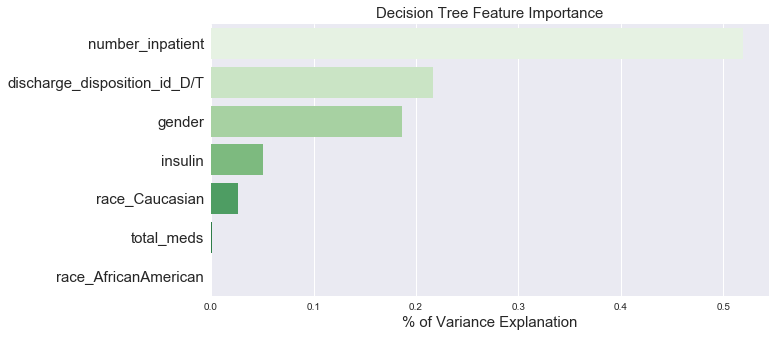

In [104]:
plt.figure(figsize=(10, 5))
sns.barplot('importance', 'feature', data= newdf, palette='Greens')
plt.title('Decision Tree Feature Importance', size= 15)
plt.xlabel('% of Variance Explanation', size= 15)
plt.ylabel('')
plt.yticks(size=15)